In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from tqdm import tqdm

import skimage.io
import skimage.segmentation
import skimage.morphology

import sys
__file__ = 'full_experiment.ipynb'
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

import utils.dirtools  # utils package should has __init__.py in it
import utils.augmentation
import utils.model_builder
import utils.data_provider
import utils.metrics
import utils.objectives
import utils.evaluation

import keras.backend
import keras.callbacks
import keras.layers
import keras.models
import keras.optimizers
from keras import backend as K
import tensorflow as tf

from config import config_vars

Using TensorFlow backend.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# build session running on GPU 1
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
# configuration.gpu_options.visible_device_list = "0, 1"
session = tf.Session(config = configuration)

# apply session
keras.backend.set_session(session)

In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [5]:
config_vars["root_directory"] = 'DATA/LineageTracking/'
experiment_name = '10'

In [6]:
config_vars = utils.dirtools.setup_working_directories(config_vars)
config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

In [7]:
config_vars

{'root_directory': 'DATA/LineageTracking/',
 'max_training_images': 0,
 'create_split_files': False,
 'training_fraction': 0.5,
 'validation_fraction': 0.25,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 25,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 10,
 'val_batch_size': 10,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': 'DATA/LineageTracking/raw_images/',
 'raw_annotations_dir': 'DATA/LineageTracking/raw_annotations/',
 'path_files_training': 'DATA/LineageTracking/training.txt',
 'path_files_validation': 'DATA/LineageTracking/validation.txt',
 'path_files_test': 'DATA/LineageTracking/test.txt',
 'normalized_images_dir': 'DATA/LineageTracking/norm_images/',
 'boundary_labels_dir': 'DATA/LineageTracking/boun

In [8]:
config_vars["rough_labels_dir"] = 'DATA/DNA_FISH/rough_labels/'

### PREPROCESS

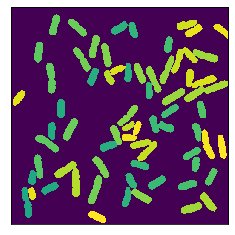

In [8]:
img = skimage.io.imread('DATA/FISH/raw_annotations/0009.png')

# make graph easier to look
inc = lambda x: x if x == 0 else x + 100
inc = np.vectorize(inc)
img = inc(img)

plt.xticks([])
plt.yticks([])
plt.imshow(img)

<a list of 100 Patch objects>

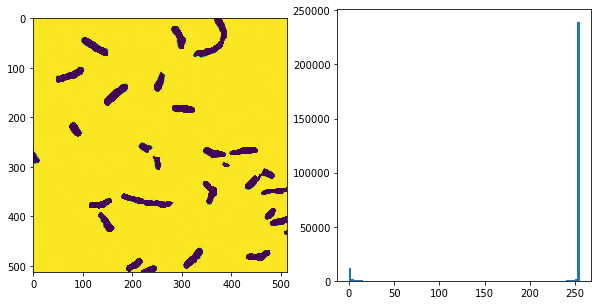

In [10]:
file_list = os.listdir(config_vars["rough_labels_dir"])
file_list = [x for x in file_list if x.endswith('jpg')]
img = skimage.io.imread(config_vars["rough_labels_dir"] + file_list[-1])

figure, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img)
ax[1].hist(img.flatten(), bins=100)[2]

In [11]:
def preprocess_rough_label(image_name):
    """fix rough label from double dip to 0/255
    
    name change to 0000.png format
    remove old file
    
    """
    img_name_list = image_name.split('.')
    new_name = img_name_list[0] + '.png'
    lb = skimage.io.imread(config_vars["rough_labels_dir"] + image_name)
    os.remove(config_vars["rough_labels_dir"] + image_name)
    buffer = np.zeros((lb.shape))
    buffer[lb > 100] = 255
    skimage.io.imsave(config_vars["rough_labels_dir"] + new_name, buffer)    

In [10]:
os.makedirs(config_vars["normalized_images_dir"], exist_ok=True)
os.makedirs(config_vars["boundary_labels_dir"], exist_ok=True)

In [16]:
# normalize images

if config_vars["transform_images_to_PNG"]:
    filelist = sorted(os.listdir(config_vars["raw_images_dir"]))
    filelist = [x for x in filelist if x.endswith('tif')]
    # run over all raw images
    for filename in tqdm(filelist):
        # load image and its annotation
        orig_img = skimage.io.imread(config_vars["raw_images_dir"] + filename)       
        # normalize to [0,1]
        percentile = 99.9
        high = np.percentile(orig_img, percentile)  # maximum for all image
        low = np.percentile(orig_img, 100-percentile)

        img = np.minimum(high, orig_img)
        img = np.maximum(low, img)

        # gives float64, thus cast to 8 bit later
        img = (img - low) / (high - low) 
        img = skimage.img_as_ubyte(img) 

        skimage.io.imsave(config_vars["normalized_images_dir"] + filename[:-3] + 'png', img)    
else:
    config_vars["normalized_images_dir"] = config_vars["raw_images_dir"]

  0%|          | 0/77 [00:00<?, ?it/s]/home/lanbowen23/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 77/77 [00:02<00:00, 28.75it/s]


In [10]:
# segmentation to boundary

filelist = sorted(os.listdir(config_vars["raw_annotations_dir"]))
filelist = [x for x in filelist if x.endswith('png')]
total_objects = 0

# run over all raw images
for filename in tqdm(filelist):
    # GET ANNOTATION
    annot = skimage.io.imread(config_vars["raw_annotations_dir"] + filename)
    
    # label the annotations nicely to prepare for future filtering operation
    annot = skimage.morphology.label(annot)
    total_objects += len(np.unique(annot)) - 1
    
    # filter small objects, e.g. micronulcei
    annot = skimage.morphology.remove_small_objects(annot, min_size=config_vars["min_nucleus_size"])
    # find boundaries
    boundaries = skimage.segmentation.find_boundaries(annot)
    # make the boundary wider
    for k in range(2, config_vars["boundary_size"], 2):
        boundaries = skimage.morphology.binary_dilation(boundaries)
        
    # 3-CHANNEL BINARY LABEL
    # prepare buffer for binary label
    label_binary = np.zeros((annot.shape + (3,)))  # cannot use dtype=np.uint8 here
    # write binary label
    label_binary[(annot == 0) & (boundaries == 0), 0] = 1  # bg
    label_binary[(annot != 0) & (boundaries == 0), 1] = 1  # cell
    label_binary[boundaries == 1, 2] = 1  # boundary
    # Convert an image to unsigned byte format, with values in [0, 255]
    label_binary = skimage.img_as_ubyte(label_binary)
    # save it - converts image to range from 0 to 255
    skimage.io.imsave(config_vars["boundary_labels_dir"] + filename, label_binary)
    
print("Total objects: ",total_objects)

100%|██████████| 77/77 [00:07<00:00, 10.53it/s]

Total objects:  1132


### TRAIN

#### Set Up Datasets

In [17]:
# get all file names in norm_dir

file_list = os.listdir(config_vars["normalized_images_dir"])
image_list = [x for x in file_list if x.endswith("png")]
len(image_list)

77

In [18]:
# NEED TO: set up train-valid split EVERY-TIME
def create_image_lists(dir_raw_images):
    file_list = os.listdir(dir_raw_images)
    image_list = [x for x in file_list if x.endswith("png")]
    image_list = sorted(image_list)

    image_list_train_aug = []
    image_list_test = []
    
    image_list_random = image_list
    random.shuffle(image_list_random)
    image_list_train = image_list_random[:50]
    image_list_validation = image_list_random[50:]
    
#     image_list_train = []
#     image_list_validation = image_list

    return image_list_train, image_list_test, image_list_validation, image_list_train_aug

In [19]:
[list_training, list_test, list_validation, list_training_aug] = create_image_lists(
    config_vars["normalized_images_dir"],
#         config_vars["training_fraction"],
#         config_vars["validation_fraction"]
)

utils.dirtools.write_path_files(config_vars["path_files_training"], list_training)
utils.dirtools.write_path_files(config_vars["path_files_test"], list_test)
utils.dirtools.write_path_files(config_vars["path_files_validation"], list_validation)

data_partitions = utils.dirtools.read_data_partitions(config_vars, load_augmented=False)

##### data generator

In [23]:
train_gen = utils.data_provider.random_sample_generator(
    config_vars["normalized_images_dir"],
#     config_vars["rough_labels_dir"],  # for 2 channels
    config_vars["boundary_labels_dir"],
    data_partitions["training"],
    config_vars["batch_size"],
    config_vars["pixel_depth"],
    config_vars["crop_size"],
    config_vars["crop_size"],
    config_vars["rescale_labels"]
)

In [24]:
val_gen = utils.data_provider.single_data_from_images(
     config_vars["normalized_images_dir"],
#      config_vars["rough_labels_dir"],
     config_vars["boundary_labels_dir"],
     data_partitions["validation"],
     config_vars["val_batch_size"],
     config_vars["pixel_depth"],
     config_vars["crop_size"],
     config_vars["crop_size"],
     config_vars["rescale_labels"]
)

#### Traininig Model

In [25]:
input_channel = 1

In [26]:
# build model
model = utils.model_builder.get_model_3_class(config_vars["crop_size"], config_vars["crop_size"],
                                               activation=None, input_channel=input_channel)
# model.summary()

In [26]:
#loss = "categorical_crossentropy"
loss = utils.objectives.weighted_crossentropy

metrics = [keras.metrics.categorical_accuracy, 
           utils.metrics.channel_recall(channel=0, name="background_recall"), 
           utils.metrics.channel_precision(channel=0, name="background_precision"),
           utils.metrics.channel_recall(channel=1, name="interior_recall"), 
           utils.metrics.channel_precision(channel=1, name="interior_precision"),
           utils.metrics.channel_recall(channel=2, name="boundary_recall"), 
           utils.metrics.channel_precision(channel=2, name="boundary_precision"),
          ]

optimizer = keras.optimizers.RMSprop(lr=config_vars["learning_rate"])

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [33]:
# Callbacks
log_folder = 'logs/'
csv = keras.callbacks.CSVLogger(filename=config_vars["csv_log_file"])
tboard = keras.callbacks.TensorBoard(log_dir=log_folder + experiment_name, 
                                      histogram_freq=0, 
                                      batch_size=32, 
                                      write_graph=True, 
                                      write_grads=False, write_images=True,
                                      update_freq='epoch')
# add ModelCheckpoints
# monitor val-loss
weights_filename = log_folder + experiment_name + '/model-{epoch:02d}-{val_loss:.2f}.h5'
modelckp = keras.callbacks.ModelCheckpoint(weights_filename, verbose=1, period=10,
                                     save_best_only=False, save_weights_only=True)

# min_delta: threshold for measuring the new optimum,
#       to only focus on significant changes.
# cooldown: number of epochs to wait before resuming
#       normal operation after lr has been reduced.
# reducelr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
#                                              verbose=1, mode='min', min_lr=1e-7, 
#                                              cooldown=10, min_delta=1e-4)
# min_lr could be smaller

In [34]:
def feed_inputs():
    partition = "validation"  # training
    image_names = [os.path.join(config_vars["normalized_images_dir"], f) \
                   for f in data_partitions[partition]]
    image_names_2 = [os.path.join(config_vars["rough_labels_dir"], f) \
                   for f in data_partitions[partition]]

    imagebuffer = skimage.io.imread_collection(image_names)
    imagebuffer_2 = skimage.io.imread_collection(image_names_2)

    images = imagebuffer.concatenate()
    images_2 = imagebuffer_2.concatenate()

    dim1 = 256
    dim2 = 256
    images = images[:, 0:dim1, 0:dim2]
    images_2 = images_2[:, 0:dim1, 0:dim2]
    images = images.reshape((-1, dim1, dim2, 1))
    images_2 = images_2.reshape((-1, dim1, dim2, 1))
    images = np.stack((images, images_2), axis=3)
    images = np.squeeze(images)
    # preprocess (assuming images are encoded as 8-bits in the preprocessing step)
    images = images / 255
    index = random.randint(0,11)  # []闭区间
    return np.expand_dims(images[index], axis=0)

In [35]:
def make_image(tensor):
    """
    Convert an numpy representation image to Image protobuf.
    Copied from https://github.com/lanpa/tensorboard-pytorch/
    """
    from PIL import Image
    import matplotlib
    height, width, channel = tensor.shape
    tensor = tensor.astype('uint8')
    tensor = 40 * tensor # make it visible
    image = Image.fromarray(tensor)  # cannot handle
    import io
    output = io.BytesIO()
    image.save(output, format='PNG')
    image_string = output.getvalue()
    output.close()
    return tf.Summary.Image(height=height,
                         width=width,
                         colorspace=channel,
                         encoded_image_string=image_string)

class TensorBoardImage(keras.callbacks.Callback):
    def __init__(self, tag, exper_name, feed_inputs):
        super().__init__() 
        self.tag = tag
        self.exper_name = exper_name
        self.feed_inputs = feed_inputs
        self.writer = tf.summary.FileWriter('./logs/' + self.exper_name + '/images')

    def on_epoch_end(self, epoch, logs={}):
        # Load image
        feature = self.feed_inputs()
        img = np.squeeze(K.get_session().run(self.model.output, \
                            feed_dict = {self.model.input:feature}))
        # Do something to the image
        # img = (255 * skimage.util.random_noise(img)).astype('uint8')

        image = make_image(img)
        summary = tf.Summary(value=[tf.Summary.Value(tag=self.tag, image=image)])
        self.writer.add_summary(summary, epoch)

        return

tbimage = TensorBoardImage('Output', experiment_name, feed_inputs)

In [36]:
callbacks = [csv, tboard, modelckp] # tbimage reducelr]

In [ ]:
# load weights
weight_h5_file = 'DATA/FISH/experiments/03/model.hdf5'
if os.path.isfile(weight_h5_file):
    try:
        model.load_weights(weight_h5_file)
    except:
        print('the model {} can not  be loaded'.format(weight_h5_file))
        pass

In [37]:
config_vars["epochs"] = 200
config_vars["steps_per_epoch"] = 500

In [ ]:
# TRAIN
statistics = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=config_vars["steps_per_epoch"],
    epochs=config_vars["epochs"],
    validation_data=val_gen,
    validation_steps=int(len(data_partitions["validation"])/config_vars["val_batch_size"]),
    callbacks=callbacks,
    verbose = 1
)
print('Done! :)')

# save one weight at the end of the training
model.save_weights(config_vars["model_file"])

Epoch 1/200
500/500 [==============================] - 154s 307ms/step - loss: 0.2459 - categorical_accuracy: 0.9277 - background_recall: 0.9411 - background_precision: 0.9908 - interior_recall: 0.7457 - interior_precision: 0.6755 - boundary_recall: 0.8982 - boundary_precision: 0.2855 - val_loss: 0.2284 - val_categorical_accuracy: 0.9361 - val_background_recall: 0.9521 - val_background_precision: 0.9855 - val_interior_recall: 0.6124 - val_interior_precision: 0.5251 - val_boundary_recall: 0.7514 - val_boundary_precision: 0.2384
Epoch 2/200
242/500 [=============>................] - ETA: 1:19 - loss: 0.2229 - categorical_accuracy: 0.9333 - background_recall: 0.9470 - background_precision: 0.9901 - interior_recall: 0.7438 - interior_precision: 0.6914 - boundary_recall: 0.8967 - boundary_precision: 0.3017

### PREDICT

In [39]:
partition = "validation"  # training
image_names = [os.path.join(config_vars["normalized_images_dir"], f) \
               for f in data_partitions[partition]]
# image_names_2 = [os.path.join(config_vars["rough_labels_dir"], f) \
#                for f in data_partitions[partition]]

imagebuffer = skimage.io.imread_collection(image_names)
# imagebuffer_2 = skimage.io.imread_collection(image_names_2)

images = imagebuffer.concatenate()
# images_2 = imagebuffer_2.concatenate()

dim1 = images.shape[1]
dim2 = images.shape[2]
images = images.reshape((-1, dim1, dim2, 1))

# images_2 = images_2.reshape((-1, dim1, dim2, 1))
# images = np.stack((images, images_2), axis=3)
# images = np.squeeze(images)
# preprocess (assuming images are encoded as 8-bits in the preprocessing step)

images = images / 255

In [40]:
images.shape

(27, 512, 512, 1)

In [41]:
# build model and load weights
model = utils.model_builder.get_model_3_class(dim1, dim2, input_channel=input_channel)
model.load_weights(config_vars["model_file"])

predictions = model.predict(images, batch_size=1)

In [37]:
def empty_dir(folder):
    print('empty directory: ', folder)
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

In [38]:
empty_dir(config_vars["probmap_out_dir"])
empty_dir(config_vars["labels_out_dir"])

empty directory:  DATA/DNA_FISH/experiments/06/out/prob/
empty directory:  DATA/DNA_FISH/experiments/06/out/segm/


In [ ]:
# boundary to segmentation

for i in range(len(images)):
    filename = imagebuffer.files[i]
    filename = os.path.basename(filename)
    print(filename)
    
    probmap = predictions[i].squeeze()
    skimage.io.imsave(config_vars["probmap_out_dir"] + filename, probmap)
    
    # fix probmap
    pred = utils.metrics.probmap_to_pred(probmap, config_vars["boundary_boost_factor"])
    label = utils.metrics.pred_to_label(pred, config_vars["cell_min_size"])
    skimage.io.imsave(config_vars["labels_out_dir"] + filename, label)
    
#     if (i < 3):
    f, ax = plt.subplots(1,3, figsize=(14,5))
    ax[0].imshow(probmap)
    ax[1].imshow(pred)
    ax[2].imshow(label)
    # remove the x and y ticks
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    plt.show()
#         plt.imshow(probmap)
#         plt.show()
#         plt.imshow(pred)
#         plt.show()
#         plt.imshow(label)
#         plt.show() 


### Evaluation

In [ ]:
# Display prediction along with ground truth to visualize errors

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)

    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))  # become 3 channels
#     A = ground_truth.copy()
#     B = prediction.copy()
#     A[A > 0] = 1
#     B[B > 0] = 1
#     D = A - B
    
    # Object-level errors
    C = IOU.copy()
    C[C >= threshold] = 1
    C[C < threshold] = 0
    missed = np.where(np.sum(C, axis=1) == 0)[0]
    extra = np.where(np.sum(C, axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 4, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects: " + str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors: " + str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:" + str(len(np.unique(prediction))))
    ax[3].imshow(IOU)
    ax[3].set_title(image_name)

In [ ]:
all_images = data_partitions[partition]  # validation

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in all_images:
    # Load ground truth data
    img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
    ground_truth = skimage.io.imread(img_filename)
    if len(ground_truth.shape) == 3:
        ground_truth = ground_truth[:,:,0]
    
    # Transform to label matrix
    ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    prediction = skimage.io.imread(pred_filename)
    
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # Relabel objects 
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0]
    
    # Compute evaluation metrics
    # Add result into pd dataframe one by one
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    if image_name == all_images[0]:
        show(ground_truth, prediction, image_name=image_name)

In [ ]:
average_performance = results.groupby("Threshold").mean().reset_index()
average_performance

In [ ]:
R = results.groupby("Image").mean().reset_index()
R.sort_values(by="F1", ascending=False)

In [ ]:
g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

In [ ]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)

In [ ]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0, 250, 625, 900, 10000], # Area intervals
        labels = ["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

# Summarize splits and merges

print("Splits:", np.sum(splits_merges["Splits"]))
print("Merges:", np.sum(splits_merges["Merges"]))

# Report false positives

print("Extra objects (false postives): ", 
      results[results["Threshold"].round(3) == 0.7].sum()["FP"])